# Demo - 2D Data

In [1]:
import pandas as pd
import numpy as np
from bayesnewton.utils import discretegrid
import bayesnewton
import objax
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from tqdm.notebook import trange, tqdm
# import tikzplotlib

rng = np.random.RandomState(123)

In [2]:
url = "https://raw.githubusercontent.com/AaltoML/BayesNewton/main/data/TRI2TU-data.csv"

# data = np.loadtxt(url, delimiter=",")
data = pd.read_csv(url, header=None)

print(data.head(10))
print(data.describe())

data = data.values

      0     1
0   7.8   9.2
1  10.7   4.8
2  11.3  11.0
3  16.6   6.8
4   1.2  24.4
5   5.5  30.5
6   8.8  23.4
7  18.6  49.5
8   3.2  63.3
9   9.4  72.5
                  0             1
count  12929.000000  12929.000000
mean     582.438223    278.408921
std      256.100622    144.174701
min        0.300000      0.200000
25%      395.200000    153.500000
50%      624.100000    295.300000
75%      772.900000    408.900000
max      999.900000    499.900000


In [3]:
num_data, num_dim = data.shape
print(f"Num Data: {num_data:,}")
print(f"Num Dims: {num_dim}")

Num Data: 12,929
Num Dims: 2


In [4]:
data[:10]

array([[ 7.8,  9.2],
       [10.7,  4.8],
       [11.3, 11. ],
       [16.6,  6.8],
       [ 1.2, 24.4],
       [ 5.5, 30.5],
       [ 8.8, 23.4],
       [18.6, 49.5],
       [ 3.2, 63.3],
       [ 9.4, 72.5]])

In [5]:
# spatial grid point (y-axis)
nx = 50
ny = 30
print(f"Grid Points (x): {nx}")

# temporal grid point (x-axis)
nt = 100
print(f"Grid Points (t): {nt}")

# binsize (delta t)
binsize = 1000 / nt

print(f"Delta t: {int(binsize)}")

# total # of data points
N = nx * nt

print(f"Data Points (Grid): {N:,}")

Grid Points (x): 50
Grid Points (t): 100
Delta t: 10
Data Points (Grid): 5,000


In [6]:
t, r, Y_ = bayesnewton.utils.discretegrid(data, [0, 1000, 0, 500], [nt, nx, ny])
t.shape, r.shape, Y_.shape

((100, 50), (100, 50), (100, 50))

In [15]:
r

array([[  0.,  10.,  20., ..., 470., 480., 490.],
       [  0.,  10.,  20., ..., 470., 480., 490.],
       [  0.,  10.,  20., ..., 470., 480., 490.],
       ...,
       [  0.,  10.,  20., ..., 470., 480., 490.],
       [  0.,  10.,  20., ..., 470., 480., 490.],
       [  0.,  10.,  20., ..., 470., 480., 490.]])

### Grids

In [8]:
# spatial grid point (y-axis)
nr = 50

# temporal grid point (x-axis)
nt = 100

# binsize (delta t)
binsize = 1000 / nt

# total # of data points
N = nr * nt

In [9]:
t, r, Y_ = bayesnewton.utils.discretegrid(data, [0, 1000, 0, 500], [nt, nr])

In [10]:
t.shape, r.shape, Y_.shape

((100, 50), (100, 50), (100, 50))

In [11]:
t_flat, r_flat, Y_flat = t.flatten(), r.flatten(), Y_.flatten()

t_flat.shape, r_flat.shape, Y_flat.shape

((5000,), (5000,), (5000,))

### Viz - Tree Locations

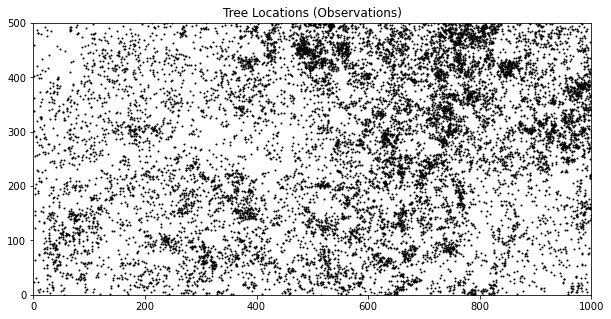

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data[:, 0], data[:, 1], "k.", markersize=2)

ax.set(title="Tree Locations (Observations)", xlim=[0, 1_000], ylim=[0, 500])

plt.show()

### Viz - Training Grid

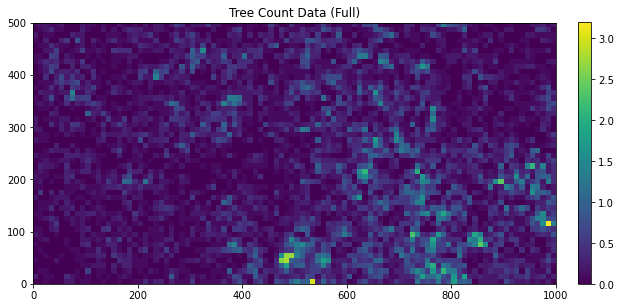

In [13]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(Y_.T / binsize, extent=[0, 1_000, 0, 500], cmap=cm.viridis)
ax.set(title="Tree Count Data (Full)")
plt.colorbar(im, fraction=0.0235, pad=0.04)
plt.show()

## Train-Test Split

In [16]:
# create random test indices
test_ind = rng.permutation(N)[:N//10]

# subset data
t_test = t_flat[test_ind]
r_test = r_flat[test_ind]
Y_test = Y_flat[test_ind]

Y_flat[test_ind] = np.nan

Y = Y_flat.reshape(nt, nr)

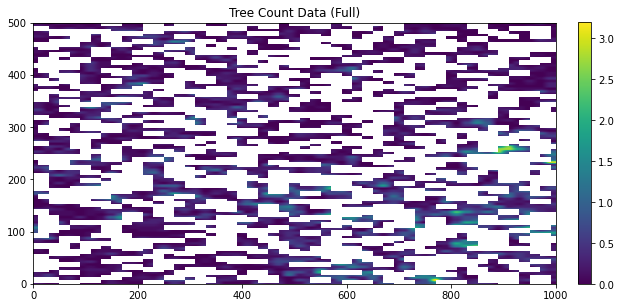

In [17]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(Y / binsize, extent=[0, 1_000, 0, 500], cmap=cm.viridis)
ax.set(title="Tree Count Data (Full)")
plt.colorbar(im, fraction=0.0235, pad=0.04)
plt.show()

In [18]:
# put test points on a grid to speed up prediction
X_test = np.concatenate([t_test[:, None], r_test[:, None]], axis=1)
print(X_test.shape, Y_test.shape)

(500, 2) (500,)


In [20]:
# X_test

In [86]:
t_test, r_test, Y_test = bayesnewton.utils.create_spatiotemporal_grid(X_test, Y_test)
t_test.shape, r_test.shape, Y_test.shape

((99, 1), (99, 50, 1), (99, 50, 1))

In [23]:
t.shape, t_test.shape

((100, 50), (500,))

In [84]:
t.shape, r.shape, Y.shape

((100, 50), (100, 50), (100, 50))

## Model

In [31]:
var_f = 1.  # GP variance
len_f = 20.  # lengthscale

# kern = bayesnewton.kernels.SpatialMatern32(variance=var_f, lengthscale=len_f, z=r[0, ...], sparse=False)
kern = bayesnewton.kernels.SpatialMatern32(variance=var_f, lengthscale=len_f, z=r[0, ...], sparse=True)
lik = bayesnewton.likelihoods.Poisson(binsize=binsize)
# lik = bayesnewton.likelihoods.Gaussian(variance=1)
# model = bayesnewton.models.VariationalGP(kernel=kern, likelihood=lik, X=x, Y=Y)
model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t, R=r, Y=Y)
# model = bayesnewton.models.MarkovVariationalGP(kernel=kern, likelihood=lik, X=t_flat, R=r_flat, Y=Y_flat)
# model = bayesnewton.models.InfiniteHorizonVariationalGP(kernel=kern, likelihood=lik, X=t, R=r, Y=Y)
# model = bayesnewton.models.MarkovVariationalGPMeanField(kernel=kern, likelihood=lik, X=t, R=r, Y=Y)

## Training

### Optimizer

In [32]:
lr_adam = 0.2
lr_newton = 0.2
iters = 10
opt_hypers = objax.optimizer.Adam(model.vars())


### Loss Function

In [33]:
energy = objax.GradValues(model.energy, model.vars())

### Training Loop

In [34]:
@objax.Function.with_vars(model.vars() + opt_hypers.vars())
def train_op():
    model.inference(lr=lr_newton)  # perform inference and update variational params
    dE, E = energy()  # compute energy and its gradients w.r.t. hypers
    opt_hypers(lr_adam, dE)
    test_nlpd_ = model.negative_log_predictive_density(X=t_test, R=r_test, Y=Y_test)
    return E, test_nlpd_


train_op = objax.Jit(train_op)


### Training

In [35]:
t0 = time.time()
for i in trange(1, iters + 1):
    loss, test_nlpd = train_op()
    print('iter %2d, energy: %1.4f, nlpd: %1.4f' % (i, loss[0], test_nlpd))
t1 = time.time()
print('optimisation time: %2.2f secs' % (t1-t0))

  0%|          | 0/10 [00:00<?, ?it/s]

2021-12-07 01:54:37.459512: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Slow compile?  XLA was built without compiler optimizations, which can be slow.  Try rebuilding with -c opt.
Compiling module jit_jit.14620
********************************


iter  1, energy: 12773.9042, nlpd: 2.5967


2021-12-07 01:55:04.017151: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:55] 
********************************
Slow compile?  XLA was built without compiler optimizations, which can be slow.  Try rebuilding with -c opt.
Compiling module jit_jit__1.14542
********************************


iter  2, energy: 11135.1639, nlpd: 2.4212
iter  3, energy: 10195.1592, nlpd: 2.3122
iter  4, energy: 9593.7756, nlpd: 2.2390
iter  5, energy: 9191.9329, nlpd: 2.1881
iter  6, energy: 8921.1668, nlpd: 2.1521
iter  7, energy: 8740.2965, nlpd: 2.1258
iter  8, energy: 8619.2531, nlpd: 2.1055
iter  9, energy: 8533.2251, nlpd: 2.0883
iter 10, energy: 8462.6231, nlpd: 2.0725
optimisation time: 62.71 secs


## Results

### Loss Function

### NLPD

In [36]:
%%time

# calculate posterior predictive distribution via filtering and smoothing at train & test locations:
print('calculating the posterior predictive distribution ...')
t0 = time.time()
posterior_mean, posterior_var = model.predict(X=t, R=r)
# posterior_mean_y, posterior_var_y = model.predict_y(X=t, R=r)
nlpd = model.negative_log_predictive_density(X=t_test, R=r_test, Y=Y_test)
t1 = time.time()
print('prediction time: %2.2f secs' % (t1-t0))
print('nlpd: %2.3f' % nlpd)

link_fn = lik.link_fn

calculating the posterior predictive distribution ...
prediction time: 6.28 secs
nlpd: 2.073


### Viz - Results

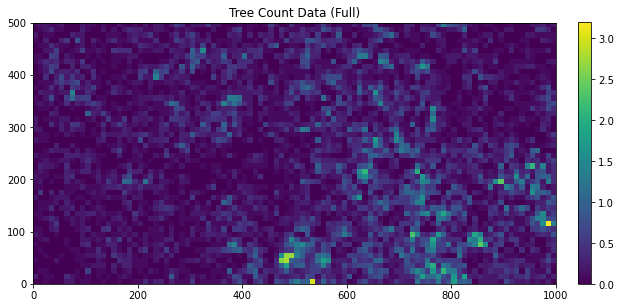

In [43]:
fig, ax = plt.subplots(figsize=(10, 5))
im = ax.imshow(Y_.T / binsize, extent=[0, 1000, 0, 500], cmap=cm.viridis)
ax.set(title="Tree Count Data (Full)")
plt.colorbar(im, fraction=0.0235, pad=0.04)
plt.show()

Text(0, 0.5, 'second spatial dimension, $r$ (metres)')

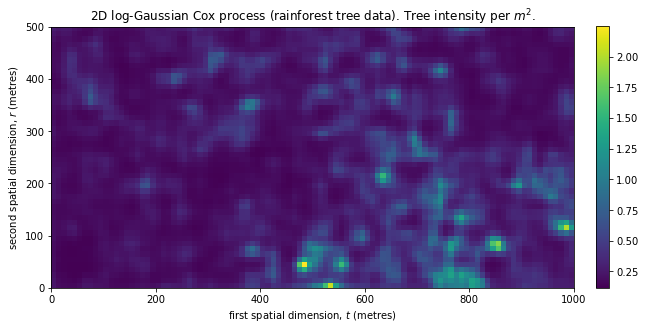

In [46]:
fig, ax = plt.subplots(figsize=(10, 5))
im = plt.imshow(link_fn(posterior_mean).T[::-1,:], cmap=cm.viridis, extent=[0, 1000, 0, 500], origin='lower')
# im = plt.imshow(posterior_mean_y.T, cmap=cmap, extent=[0, 1000, 0, 500], origin='lower')
plt.colorbar(im, fraction=0.0235, pad=0.04)
plt.xlim(0, 1000)
plt.ylim(0, 500)
# plt.title('2D log-Gaussian Cox process (rainforest tree data). Log-intensity shown.')
plt.title('2D log-Gaussian Cox process (rainforest tree data). Tree intensity per $m^2$.')
plt.xlabel('first spatial dimension, $t$ (metres)')
plt.ylabel('second spatial dimension, $r$ (metres)')